# Debug Cluster Changes

This notebook is a utility notebook for examining changes between the current branch and `master`.

**Warning:** this notebook consumes quite a bit of memory (over 32GB).

## Setup

Libraries:

In [1]:
import dvc.api
import numpy as np
import pandas as pd
import seaborn as sns

## Load Data

We need to load some data files.  We are primarily interested in the book genders.

### Current Book Genders

Load the current genders:

In [2]:
current = pd.read_parquet("book-links/cluster-genders.parquet")
current["gender"] = current["gender"].astype("category")
current.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32185879 entries, 0 to 32185878
Data columns (total 2 columns):
 #   Column   Dtype   
---  ------   -----   
 0   cluster  int32   
 1   gender   category
dtypes: category(1), int32(1)
memory usage: 153.5 MB


<AxesSubplot:xlabel='count', ylabel='gender'>

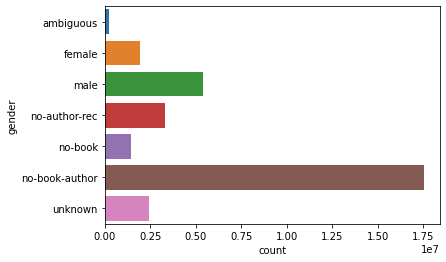

In [3]:
sns.countplot(y="gender", data=current)

In [4]:
current = current.set_index("cluster").sort_index()

### Master Book Genders

Now load the genders from the `master` branch:

In [5]:
with dvc.api.open("book-links/cluster-genders.parquet", rev="master", mode="rb") as pqf:
    master = pd.read_parquet(pqf)
master["gender"] = master["gender"].astype("category")
master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32185879 entries, 0 to 32185878
Data columns (total 2 columns):
 #   Column   Dtype   
---  ------   -----   
 0   cluster  int32   
 1   gender   category
dtypes: category(1), int32(1)
memory usage: 153.5 MB


<AxesSubplot:xlabel='count', ylabel='gender'>

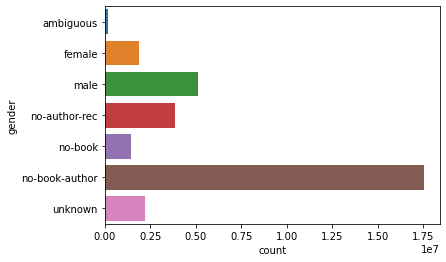

In [6]:
sns.countplot(y="gender", data=master)

In [7]:
master = master.set_index("cluster").sort_index()

### Authors

Let's load book first authors:

In [8]:
authors = pd.read_parquet("book-links/cluster-first-authors.parquet")
authors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23474948 entries, 0 to 23474947
Data columns (total 2 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   cluster      int32 
 1   author_name  object
dtypes: int32(1), object(1)
memory usage: 268.6+ MB


And the author indexes:

In [9]:
cur_au_idx = pd.read_parquet("viaf/author-name-index.parquet")
cur_au_idx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60791876 entries, 0 to 60791875
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   rec_id  uint32
 1   name    object
dtypes: object(1), uint32(1)
memory usage: 695.7+ MB


In [10]:
with dvc.api.open("viaf/author-name-index.parquet", rev="master", mode="rb") as pqf:
    old_au_idx = pd.read_parquet(pqf)
old_au_idx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61681353 entries, 0 to 61681352
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   rec_id  uint32
 1   name    object
dtypes: object(1), uint32(1)
memory usage: 705.9+ MB


And the old author names:

In [11]:
with dvc.api.open("book-links/cluster-first-authors.parquet", rev="master", mode="rb") as pqf:
    old_authors = pd.read_parquet(pqf)
old_authors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24331117 entries, 0 to 24331116
Data columns (total 2 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   cluster      int32 
 1   author_name  object
dtypes: int32(1), object(1)
memory usage: 278.4+ MB


## Tabulate Results

Let's compare gender link results.

In [12]:
genders = master.join(current, how="outer", lsuffix="_old", rsuffix="_cur")
genders.columns.name = "source"
genders.head()

source,gender_old,gender_cur
cluster,,
100000001,no-author-rec,no-author-rec
100000002,no-author-rec,no-author-rec
100000003,male,male
100000004,male,male
100000005,female,female


In [13]:
gender_tall = genders.stack().to_frame(name="gender").reset_index()
gender_tall["source"] = gender_tall["source"].str.replace("gender_", "", regex=False)
gender_tall.head()

,cluster,source,gender
0,100000001,old,no-author-rec
1,100000001,cur,no-author-rec
2,100000002,old,no-author-rec
3,100000002,cur,no-author-rec
4,100000003,old,male


<AxesSubplot:xlabel='count', ylabel='gender'>

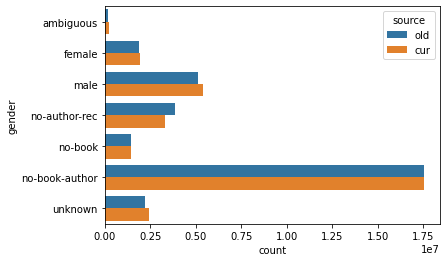

In [14]:
sns.countplot(y="gender", hue="source", data=gender_tall)

In [15]:
pd.crosstab(genders["gender_old"], genders["gender_cur"])

gender_cur,ambiguous,female,male,no-author-rec,no-book,no-book-author,unknown
gender_old,,,,,,,
ambiguous,198502,186,533,82,0,0,39
female,4281,1862861,0,0,0,0,0
male,6880,0,5099696,3,0,0,0
no-author-rec,7674,58038,259604,3301200,0,0,255683
no-book,0,0,0,0,433755,0,0
no-book-author,0,0,0,0,0,17515835,0
unknown,3017,2956,27402,51,0,0,2161886


## Examine Unmatched Books

Our initial question is to study why we have books without author records matching.

In [16]:
cur_nar_mask = current["gender"] == "no-author-rec"
cur_nar_mask.describe()

count     32185879
unique           2
top          False
freq      28884543
Name: gender, dtype: object

In [17]:
old_nar_mask = master["gender"] == "no-author-rec"
old_nar_mask.describe()

count     32185879
unique           2
top          False
freq      28303680
Name: gender, dtype: object

Get the books that are now NAR, but were not before:

In [18]:
newly_nar = cur_nar_mask & ~old_nar_mask
newly_nar.sum()

136

Now let's try to look at why. What are these author names?

In [19]:
nnar = master[newly_nar]
nnar_auth = pd.merge(nnar.reset_index(), old_authors)
nnar_auth.head()

C:\Users\michaelekstrand\AppData\Local\Temp\ipykernel_29772\2118428709.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  nnar = master[newly_nar]


,cluster,gender,author_name
0,100627655,male,"Peter, Walker"
1,100680709,unknown,"William, Martin"
2,100682497,unknown,"Abraham, Rothberg"
3,100803580,ambiguous,
4,100803580,ambiguous,.


What does that look like in current data?

In [20]:
nnar_cauth = pd.merge(current[newly_nar].reset_index(), authors).head()
nnar_cauth

C:\Users\michaelekstrand\AppData\Local\Temp\ipykernel_29772\394937405.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  nnar_cauth = pd.merge(current[newly_nar].reset_index(), authors).head()


,cluster,gender,author_name
0,100627655,no-author-rec,"Peter, Walker"
1,100680709,no-author-rec,"William, Martin"
2,100682497,no-author-rec,"Abraham, Rothberg"
3,100803580,no-author-rec,
4,100813338,no-author-rec,


Grab that first cluster.

In [21]:
sc = nnar_auth.iloc[0, 0]
sought = nnar_auth.loc[nnar_auth["cluster"] == sc, "author_name"]
sought

0    Peter, Walker
Name: author_name, dtype: object

Find them in the old data:

In [22]:
matched = old_au_idx[old_au_idx["name"].isin(sought)]
matched

,rec_id,name
41009805,18890592,"Peter, Walker"


What does the current data say for those records?

In [23]:
cur_ver = cur_au_idx[cur_au_idx["rec_id"].isin(matched["rec_id"])].copy()
cur_ver["repr"] = cur_ver["name"].apply(repr)
cur_ver

,rec_id,name,repr
40337673,18890592,Peter Walker,'Peter Walker'
52517659,18890592,"Walker, Peter","'Walker, Peter'"


In [24]:
csc = nnar_cauth.iloc[0, 0]
cso = nnar_cauth.loc[nnar_cauth["cluster"] == csc, "author_name"]
cmatch = cur_au_idx[cur_au_idx["name"].isin(cso)]
cmatch

,rec_id,name
